In [1056]:
# MANAN KALRA
# manankalra29@gmail.com

### Task:
##### To generate insights from provided 2019 CVE data

# ------------------------------

# 1. Data Loading

In [957]:
import numpy as np
import pandas as pd
from pandas.io import json # as we'll be dealing with json data at first

import requests
from urllib.request import urlopen

from io import BytesIO
from zipfile import ZipFile

In [958]:
url = 'https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-2019.json.zip'
save = 'nvdcve-1.1-2019.json'

u = urlopen(url)
start = u.read()
temp1 = (BytesIO(start))
temp2 = ZipFile(temp1)
end = temp2.extract(save)
data = pd.read_json(end)

# Sources used in order to deal with zipped files and json normalization:

# https://stackoverflow.com/questions/5710867/downloading-and-unzipping-a-zip-file-without-writing-to-disk
# https://stackoverflow.com/questions/18885175/read-a-zipped-file-as-a-pandas-dataframe
# https://stackoverflow.com/questions/45325208/python-json-normalize-a-pandas-series-gives-typeerror

# 2. Data Cleaning/Manipulation

##### Looking at the JSON file, there are 6 keys under the root. In this case, we need to extract relevant information from 
##### the 'CVE_Items' key and store it in a pandas dataframe for further analysis.

In [959]:
# extracting just the CVE_Items subset
CVE_Items = json.json_normalize(data['CVE_Items'])

In [960]:
# concatenating all nested information into a single dataframe
# makes it easy to extract relevant information
data = pd.concat([data.reset_index(), CVE_Items], axis=1)
data = data.drop(['index', 'CVE_Items'], axis=1)

##### The following columns are of relevance to us:

###### 'cve.CVE_data_meta.ID'                 -----> cve_id

###### 'cve.description.description_data'     -----> description

###### 'cve.problemtype.problemtype_data'     -----> cwe

###### 'publishedDate'                        -----> publishedDate

###### 'lastModifiedDate'                     -----> lastModifieddate

###### 'impact.baseMetricV2.cvssV2.baseScore' -----> cvssV2_baseScore

###### 'cve.references.reference_data'        -----> number of references, exploitdb_flag

In [961]:
data.columns

Index(['CVE_data_type', 'CVE_data_format', 'CVE_data_version',
       'CVE_data_numberOfCVEs', 'CVE_data_timestamp',
       'configurations.CVE_data_version', 'configurations.nodes',
       'cve.CVE_data_meta.ASSIGNER', 'cve.CVE_data_meta.ID', 'cve.data_format',
       'cve.data_type', 'cve.data_version', 'cve.description.description_data',
       'cve.problemtype.problemtype_data', 'cve.references.reference_data',
       'impact.baseMetricV2.acInsufInfo',
       'impact.baseMetricV2.cvssV2.accessComplexity',
       'impact.baseMetricV2.cvssV2.accessVector',
       'impact.baseMetricV2.cvssV2.authentication',
       'impact.baseMetricV2.cvssV2.availabilityImpact',
       'impact.baseMetricV2.cvssV2.baseScore',
       'impact.baseMetricV2.cvssV2.confidentialityImpact',
       'impact.baseMetricV2.cvssV2.integrityImpact',
       'impact.baseMetricV2.cvssV2.vectorString',
       'impact.baseMetricV2.cvssV2.version',
       'impact.baseMetricV2.exploitabilityScore',
       'impact.baseMetr

In [962]:
data = data[['cve.CVE_data_meta.ID', 
             'cve.description.description_data', # needs cleaning
             'cve.problemtype.problemtype_data', # needs cleaning
             'publishedDate', # needs cleaning
             'lastModifiedDate', # needs cleaning
             'impact.baseMetricV2.cvssV2.baseScore', 
             'cve.references.reference_data']] # needs cleaning

In [963]:
len(data)

14582

In [965]:
# cleaning for description
# e.g. - [{'lang': 'en', 'value': 'The social-warfare plugin before 3.5.3 for WordPress has stored XSS via the wp-admin/admin-post.php?swp_debug=load_options swp_url parameter, as exploited in the wild in March 2019. This affects Social Warfare and Social Warfare Pro.'}]
description = []
for d in data['cve.description.description_data']:
    temp = d[0]['value']
    if temp != '':
        description.append(desc)
    else:
        description.append(np.nan)

In [966]:
data['description'] = description
data = data.drop(['cve.description.description_data'], axis=1)

In [968]:
data.head()

,cve.CVE_data_meta.ID,cve.problemtype.problemtype_data,publishedDate,lastModifiedDate,impact.baseMetricV2.cvssV2.baseScore,cve.references.reference_data,description
0,CVE-2019-0001,"[{'description': [{'lang': 'en', 'value': 'CWE...",2019-01-15T21:29Z,2019-10-09T23:43Z,7.1,[{'url': 'http://www.securityfocus.com/bid/106...,Receipt of a malformed packet on MX Series dev...
1,CVE-2019-0002,"[{'description': [{'lang': 'en', 'value': 'CWE...",2019-01-15T21:29Z,2019-10-09T23:43Z,7.5,[{'url': 'http://www.securityfocus.com/bid/106...,Receipt of a malformed packet on MX Series dev...
2,CVE-2019-0003,"[{'description': [{'lang': 'en', 'value': 'CWE...",2019-01-15T21:29Z,2019-10-09T23:43Z,4.3,[{'url': 'http://www.securityfocus.com/bid/106...,Receipt of a malformed packet on MX Series dev...
3,CVE-2019-0004,"[{'description': [{'lang': 'en', 'value': 'CWE...",2019-01-15T21:29Z,2019-10-09T23:43Z,2.1,"[{'url': 'https://kb.juniper.net/JSA10918', 'n...",Receipt of a malformed packet on MX Series dev...
4,CVE-2019-0005,"[{'description': [{'lang': 'en', 'value': 'CWE...",2019-01-15T21:29Z,2019-02-14T18:40Z,5.0,[{'url': 'http://www.securityfocus.com/bid/106...,Receipt of a malformed packet on MX Series dev...


In [969]:
# cleaning for cwe
# e.g. - [{'description': [{'lang': 'en', 'value': 'CWE-79'}]}]
cwe = []
for c in data['cve.problemtype.problemtype_data']:
    l = len(c[0]['description'])
    if l == 0:
        cwe.append(np.nan) # there are missing values
    else:
        # there are multiple values, max is 2
        # only choosing the first one, as presented in the dataset shown in the problem description
        
        # temp = []
        # for i in range(l):
        #     temp.append(c[0]['description'][i]['value']) 
        # cwe.append(' '.join(temp))
        
        cwe.append(c[0]['description'][0]['value'])

In [970]:
data['cwe'] = cwe
data = data.drop(['cve.problemtype.problemtype_data'], axis=1)

In [971]:
# cleaning for publishedDate, lastModifiedDate
data['publishedDate'] = pd.to_datetime(data['publishedDate']).dt.date
data['lastModifiedDate'] = pd.to_datetime(data['lastModifiedDate']).dt.date

In [972]:
# cleaning for references

# number_of_references, exploitdb_flag
num_ref, binary_exploitdb = [], []
for refs in data['cve.references.reference_data']:
    flag = 0
    num_ref.append(len(refs))
    for ref in refs:
        if ref['refsource'] == 'EXPLOIT-DB':
            flag = 1
            binary_exploitdb.append(1)
            break
    if flag == 1:
        continue
    else:
        binary_exploitdb.append(0)

In [973]:
data['number_of_references'] = num_ref
data['exploitdb_flag'] = binary_exploitdb
data = data.drop(['cve.references.reference_data'], axis=1)

In [974]:
# re-ordering columns
data = data[['cve.CVE_data_meta.ID',
             'description',
             'cwe',
             'publishedDate',
             'lastModifiedDate',
             'impact.baseMetricV2.cvssV2.baseScore',
             'number_of_references',
             'exploitdb_flag']]

In [975]:
# renaming columns
data.rename({'cve.CVE_data_meta.ID': 'cve_id', 'impact.baseMetricV2.cvssV2.baseScore': 'cvssV2_baseScore'}, axis=1, inplace=True)

In [976]:
data.head()

,cve_id,description,cwe,publishedDate,lastModifiedDate,cvssV2_baseScore,number_of_references,exploitdb_flag
0,CVE-2019-0001,Receipt of a malformed packet on MX Series dev...,CWE-400,2019-01-15,2019-10-09,7.1,4,0
1,CVE-2019-0002,Receipt of a malformed packet on MX Series dev...,CWE-20,2019-01-15,2019-10-09,7.5,3,0
2,CVE-2019-0003,Receipt of a malformed packet on MX Series dev...,CWE-20,2019-01-15,2019-10-09,4.3,2,0
3,CVE-2019-0004,Receipt of a malformed packet on MX Series dev...,CWE-200,2019-01-15,2019-10-09,2.1,1,0
4,CVE-2019-0005,Receipt of a malformed packet on MX Series dev...,CWE-400,2019-01-15,2019-02-14,5.0,2,0


In [977]:
len(data[data.isnull().any(axis=1)])

847

In [978]:
data[data.isnull().any(axis=1)].head()

,cve_id,description,cwe,publishedDate,lastModifiedDate,cvssV2_baseScore,number_of_references,exploitdb_flag
33,CVE-2019-0034,Receipt of a malformed packet on MX Series dev...,NaN,2019-04-10,2019-04-15,NaN,0,0
122,CVE-2019-0141,Receipt of a malformed packet on MX Series dev...,NaN,2020-01-25,2020-01-25,NaN,0,0
176,CVE-2019-0198,Receipt of a malformed packet on MX Series dev...,NaN,2019-03-21,2019-03-21,NaN,0,0
184,CVE-2019-0206,Receipt of a malformed packet on MX Series dev...,NaN,2019-03-14,2019-03-14,NaN,0,0
186,CVE-2019-0208,Receipt of a malformed packet on MX Series dev...,NaN,2019-04-10,2019-04-10,NaN,0,0


In [979]:
# there are 847 missing values for cwe and cssv2_baseScore
# both of them co-exist, if present
# another pattern is: description for all of them states something like - '**REJECT**...'

# it's better to get rid of these as their description states
# not a good option to impute these values
data = data.dropna()

In [980]:
len(data)

13735

In [981]:
len(np.unique(data['cve_id'])) # all are unique

13735

In [982]:
np.unique(data['cwe'])
# values like NVD-CWE-Other, NVD-CWE-noinfo should be grouped together as we do not have any information on how they differ

array(['CWE-1021', 'CWE-116', 'CWE-118', 'CWE-1187', 'CWE-1188',
       'CWE-119', 'CWE-120', 'CWE-125', 'CWE-129', 'CWE-131', 'CWE-134',
       'CWE-16', 'CWE-172', 'CWE-18', 'CWE-184', 'CWE-185', 'CWE-189',
       'CWE-19', 'CWE-190', 'CWE-191', 'CWE-20', 'CWE-200', 'CWE-203',
       'CWE-209', 'CWE-21', 'CWE-216', 'CWE-22', 'CWE-254', 'CWE-255',
       'CWE-264', 'CWE-269', 'CWE-273', 'CWE-275', 'CWE-276', 'CWE-281',
       'CWE-284', 'CWE-285', 'CWE-287', 'CWE-290', 'CWE-294', 'CWE-295',
       'CWE-297', 'CWE-306', 'CWE-307', 'CWE-310', 'CWE-311', 'CWE-312',
       'CWE-319', 'CWE-320', 'CWE-326', 'CWE-327', 'CWE-330', 'CWE-331',
       'CWE-332', 'CWE-338', 'CWE-345', 'CWE-346', 'CWE-347', 'CWE-352',
       'CWE-354', 'CWE-362', 'CWE-367', 'CWE-369', 'CWE-371', 'CWE-384',
       'CWE-388', 'CWE-399', 'CWE-400', 'CWE-401', 'CWE-404', 'CWE-407',
       'CWE-415', 'CWE-416', 'CWE-417', 'CWE-426', 'CWE-427', 'CWE-428',
       'CWE-434', 'CWE-436', 'CWE-441', 'CWE-444', 'CWE-470', 'CW

In [983]:
def group_cwe(cwe_val):
    if cwe_val == 'NVD-CWE-Other' or cwe_val == 'NVD-CWE-noinfo':
        return 'NONE'
    else:
        return cwe_val
data['cwe'] = data['cwe'].apply(group_cwe)

In [984]:
np.unique(data['cwe'])

array(['CWE-1021', 'CWE-116', 'CWE-118', 'CWE-1187', 'CWE-1188',
       'CWE-119', 'CWE-120', 'CWE-125', 'CWE-129', 'CWE-131', 'CWE-134',
       'CWE-16', 'CWE-172', 'CWE-18', 'CWE-184', 'CWE-185', 'CWE-189',
       'CWE-19', 'CWE-190', 'CWE-191', 'CWE-20', 'CWE-200', 'CWE-203',
       'CWE-209', 'CWE-21', 'CWE-216', 'CWE-22', 'CWE-254', 'CWE-255',
       'CWE-264', 'CWE-269', 'CWE-273', 'CWE-275', 'CWE-276', 'CWE-281',
       'CWE-284', 'CWE-285', 'CWE-287', 'CWE-290', 'CWE-294', 'CWE-295',
       'CWE-297', 'CWE-306', 'CWE-307', 'CWE-310', 'CWE-311', 'CWE-312',
       'CWE-319', 'CWE-320', 'CWE-326', 'CWE-327', 'CWE-330', 'CWE-331',
       'CWE-332', 'CWE-338', 'CWE-345', 'CWE-346', 'CWE-347', 'CWE-352',
       'CWE-354', 'CWE-362', 'CWE-367', 'CWE-369', 'CWE-371', 'CWE-384',
       'CWE-388', 'CWE-399', 'CWE-400', 'CWE-401', 'CWE-404', 'CWE-407',
       'CWE-415', 'CWE-416', 'CWE-417', 'CWE-426', 'CWE-427', 'CWE-428',
       'CWE-434', 'CWE-436', 'CWE-441', 'CWE-444', 'CWE-470', 'CW

In [985]:
# final dataset to perform EDA on
data.head()

,cve_id,description,cwe,publishedDate,lastModifiedDate,cvssV2_baseScore,number_of_references,exploitdb_flag
0,CVE-2019-0001,Receipt of a malformed packet on MX Series dev...,CWE-400,2019-01-15,2019-10-09,7.1,4,0
1,CVE-2019-0002,Receipt of a malformed packet on MX Series dev...,CWE-20,2019-01-15,2019-10-09,7.5,3,0
2,CVE-2019-0003,Receipt of a malformed packet on MX Series dev...,CWE-20,2019-01-15,2019-10-09,4.3,2,0
3,CVE-2019-0004,Receipt of a malformed packet on MX Series dev...,CWE-200,2019-01-15,2019-10-09,2.1,1,0
4,CVE-2019-0005,Receipt of a malformed packet on MX Series dev...,CWE-400,2019-01-15,2019-02-14,5.0,2,0


# 3. EDA

In [986]:
import matplotlib.pyplot as plt
%matplotlib inline

In [987]:
cwe_counts = data['cwe'].value_counts().sort_values(axis=0, ascending=False)
cwe_counts
# shows that some cwe codes are more prevalent than others

CWE-79      1515
CWE-20      1376
CWE-119     1037
CWE-200      960
CWE-284      672
CWE-125      646
CWE-264      437
CWE-416      418
CWE-787      383
CWE-352      380
CWE-89       379
CWE-22       305
CWE-287      274
CWE-400      256
CWE-269      250
CWE-476      226
CWE-77       213
CWE-255      206
CWE-74       185
NONE         182
CWE-78       178
CWE-732      170
CWE-434      163
CWE-190      161
CWE-120      144
CWE-254      113
CWE-611       99
CWE-94        98
CWE-399       97
CWE-522       88
            ... 
CWE-672        3
CWE-16         3
CWE-99         2
CWE-538        2
CWE-829        2
CWE-470        2
CWE-1188       2
CWE-21         2
CWE-417        2
CWE-776        2
CWE-216        2
CWE-18         1
CWE-118        1
CWE-441        1
CWE-707        1
CWE-184        1
CWE-436        1
CWE-297        1
CWE-908        1
CWE-706        1
CWE-90         1
CWE-838        1
CWE-371        1
CWE-401        1
CWE-924        1
CWE-172        1
CWE-664        1
CWE-131       

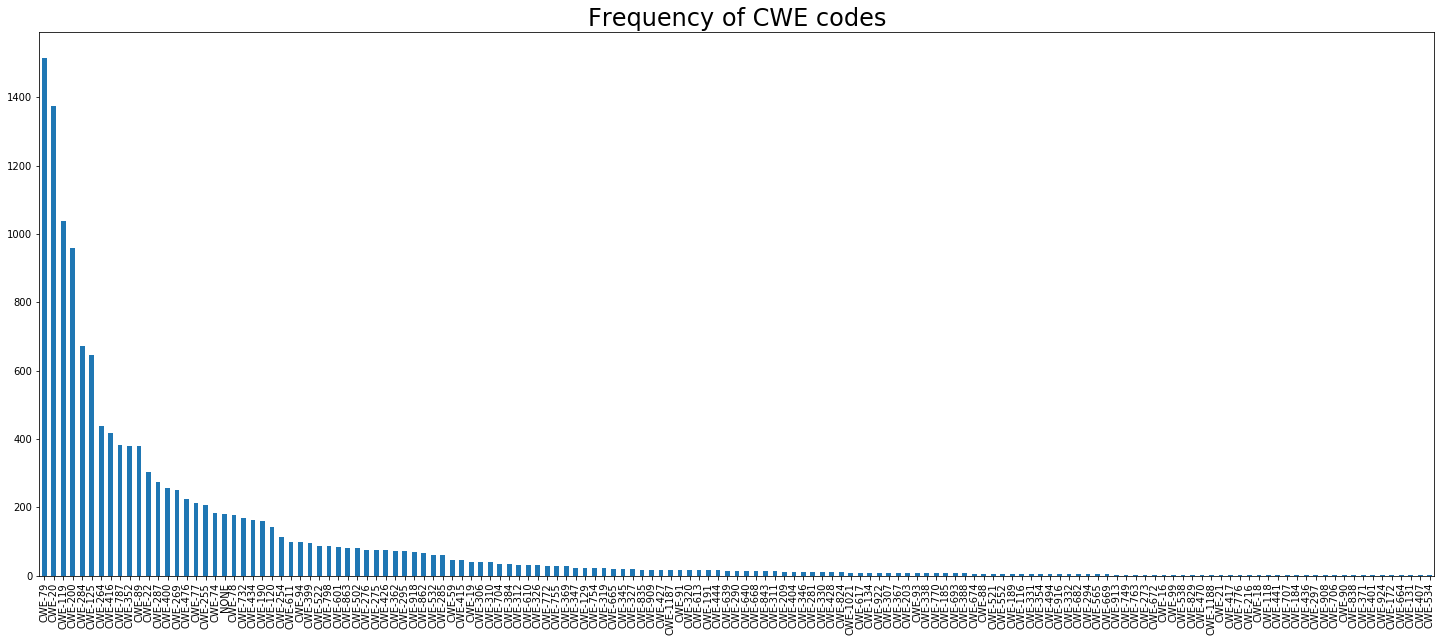

In [988]:
cwe_counts.plot(kind="bar", figsize = (25,10))
plt.title("Frequency of CWE codes", fontsize = 24)
plt.show()

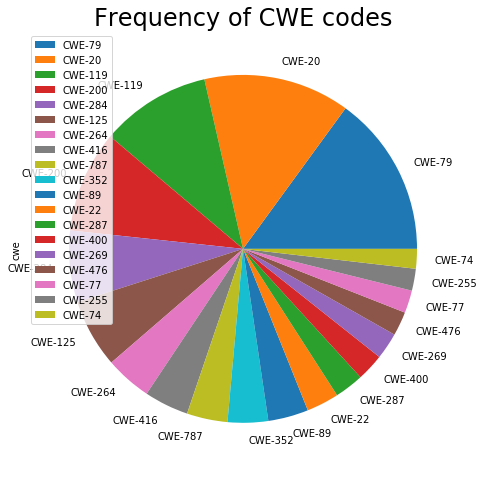

In [989]:
cwe_counts[0:19].plot(kind="pie", legend=True, figsize = (10,8))
plt.title("Frequency of CWE codes", fontsize = 24)
plt.show()

### Most common CWE codes are: CWE-79, CWE-20, CWE-119
##### According to the information on NVD website: https://nvd.nist.gov/vuln/categories, they can be described as follows:
#### CWE-79 -> The software does not neutralize or incorrectly neutralizes user-controllable input before it is placed in output that is used as a web page that is served to other users.
#### CWE-20 -> The product does not validate or incorrectly validates input that can affect the control flow or data flow of a program.
#### CWE-119 -> The software performs operations on a memory buffer, but it can read from or write to a memory location that is outside of the intended boundary of the buffer.

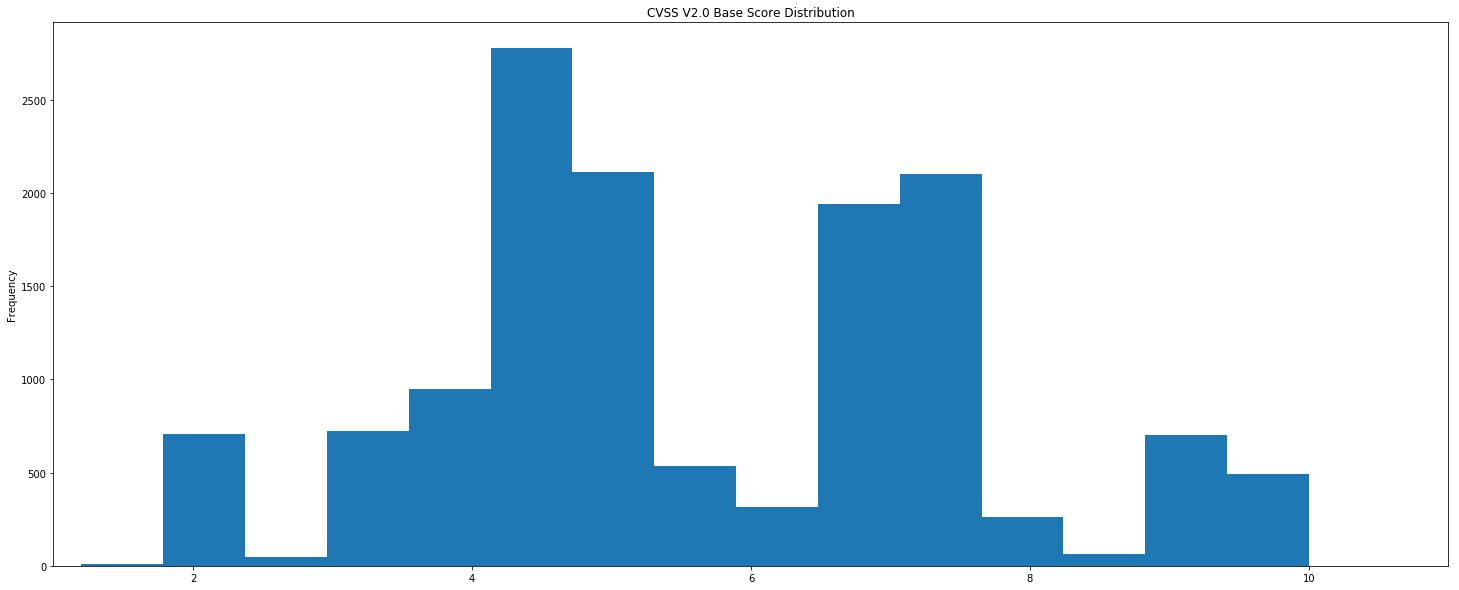

In [990]:
# in the problem dataset, CVSS 2.0 score is used to quantify the severity of the various vulnerabilities in the data.
data['cvssV2_baseScore'].plot(kind='hist', title='CVSS V2.0 Base Score Distribution', bins=15, xlim=(1,11), figsize = (25,10))
# the graph doesn't look normally distributed, not sure though, need to confirm this

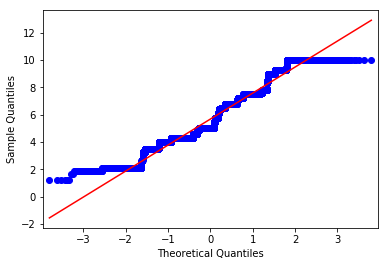

In [991]:
# further plotting for checking normality
from statsmodels.graphics.gofplots import qqplot
qqplot(data['cvssV2_baseScore'], line='s')
plt.show()
# large deviations at the ends, again it is suggesting that the scores are not normally distributed

In [992]:
# testing normality using Shapiro-Wilk test and D’Agostino’s K^2 Test
from scipy.stats import shapiro, normaltest

In [993]:
stat, p_value = shapiro(data['cvssV2_baseScore'])
stat2, p_value2 = normaltest(data['cvssV2_baseScore'])

/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [994]:
print('Statistics=%.3f, p=%.3f' % (stat, p_value))
print('Statistics=%.3f, p=%.3f' % (stat2, p_value2))

Statistics=0.955, p=0.000
Statistics=406.943, p=0.000


#### here p_value comes out to be less than 0.005 in both the cases
#### therefore, the CVSS V2.0 Base Scores are not normally distributed

In [995]:
# we can further look for a trend in mean cvss scores per cwe
cve_per_cwe = data.groupby(['cwe']).count()['cve_id'].sort_values(ascending=False)
score_per_cwe = data.groupby(['cwe']).mean()['cvssV2_baseScore'].sort_values(ascending=False)

In [996]:
summary = pd.concat([cve_per_cwe, score_per_cwe], axis=1, sort=True)
summary = summary.rename(columns={'cve_id': 'Count', 'cvssV2_baseScore': 'CVSS 2.0 Score'})
summary = summary.sort_values(by=['Count'], ascending=False)

In [997]:
summary

,Count,CVSS 2.0 Score
CWE-79,1515,4.029835
CWE-20,1376,5.830959
CWE-119,1037,7.171938
CWE-200,960,4.086250
CWE-284,672,5.205655
CWE-125,646,5.260681
CWE-264,437,6.195652
CWE-416,418,6.780144
CWE-787,383,7.023760
CWE-352,380,6.086316


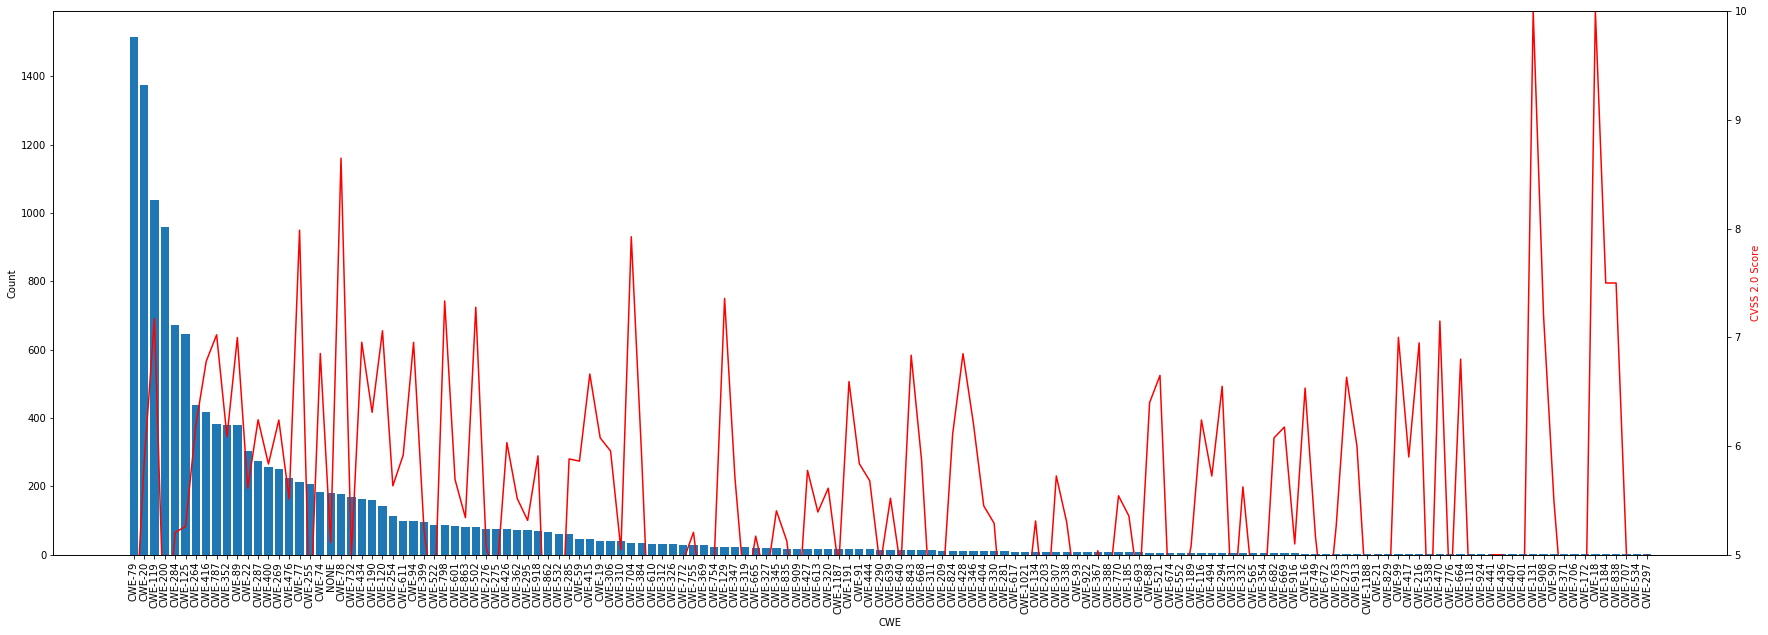

In [998]:
fig, ax1 = plt.subplots(figsize = (30,10))

ax2 = ax1.twinx()
ax1.bar(summary.index, summary["Count"])
ax2.plot(summary.index, summary["CVSS 2.0 Score"], 'red')

ax1.set_xlabel('CWE')
ax1.set_ylabel('Count')
ax2.set_ylabel('CVSS 2.0 Score', color='red')
ax2.set_ylim(bottom = 5, top = 10)
    
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
plt.show()

# Sources:

# https://stackoverflow.com/questions/14762181/adding-a-y-axis-label-to-secondary-y-axis-in-matplotlib
# https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib

#### Hard to identify any trend here because the CVSS 2.0 Score fluctuates much

In [999]:
summary[0:9]

,Count,CVSS 2.0 Score
CWE-79,1515,4.029835
CWE-20,1376,5.830959
CWE-119,1037,7.171938
CWE-200,960,4.086250
CWE-284,672,5.205655
CWE-125,646,5.260681
CWE-264,437,6.195652
CWE-416,418,6.780144
CWE-787,383,7.023760


# 4. Grouping/Clustering

In [1000]:
# to identify groups of vulnerabilities that might have common characterstics

In [1001]:
# applying k-means because our dataset is large enough and centroid of the identified clusters won't be affected by a
# few outliers.

In [1002]:
# although our CVSS V2.0 Base Scores aren't normally distributed but this won't pose a problem as they are in a fixed range
# [0-10]

In [1003]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# we need to perform silhouette analysis in order to identify the appropriate number of clusters required
# this can also be computed with cross-validation but will be a slow process if I implement it manually on such a large dataset

# Source:

# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [1004]:
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Source: Udacity

# https://github.com/udacity/machine-learning/pull/331/commits/bf0c698fb064620e05d7b723fee26dbd4fde9b9e

In [1005]:
# features

# cve_id, description, publishedDate, and lastModifiedDate won't play any role in our analysis
data_kmeans = data.drop(['cve_id', 'description', 'publishedDate', 'lastModifiedDate'], axis=1)

In [1006]:
data_kmeans = pd.get_dummies(data_kmeans)
data_kmeans = data_kmeans.apply(pd.to_numeric, errors='coerce')

In [1007]:
k_values = range(2, 11, 1) # as I'm not using a machine with high computing power, I chose to try these possible values
errors = [clustering_errors(k, data_kmeans) for k in k_values]

In [1008]:
list(zip(k_values, errors))

[(2, 0.7460377056994928),
 (3, 0.3604914146467036),
 (4, 0.39817854927284757),
 (5, 0.40524190522667675),
 (6, 0.3993470540115217),
 (7, 0.3487878566176629),
 (8, 0.3172318341118365),
 (9, 0.2870148480847253),
 (10, 0.2937524204001783)]

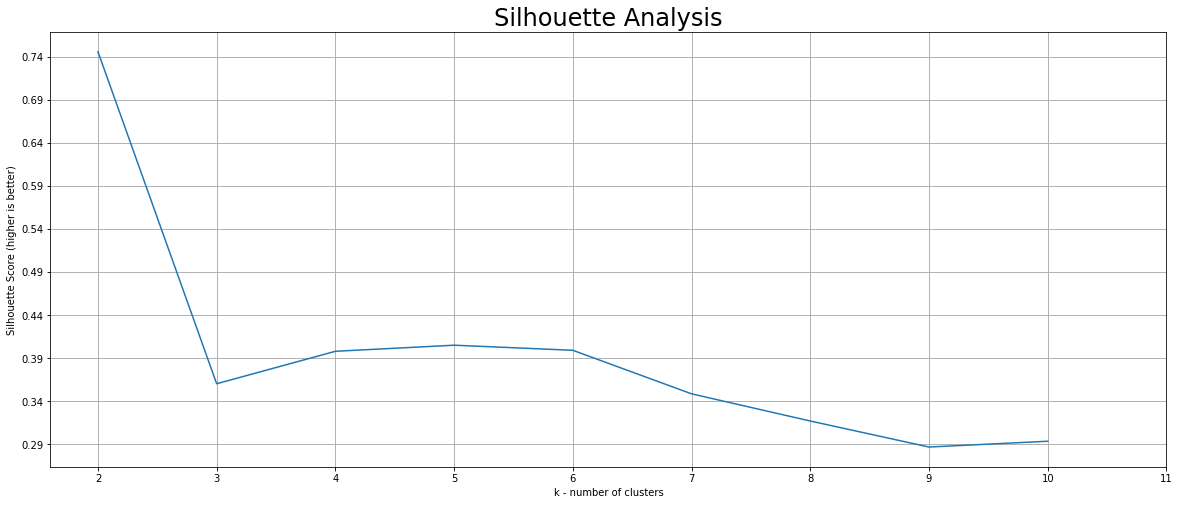

In [1009]:
# plotting k vs. silhouette score at that value
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_xlabel('k - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(k_values, errors)
plt.title("Silhouette Analysis", fontsize = 24)

# making the chart pretty
xticks = np.arange(min(k_values), max(k_values)+2, 1)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors), 2), max(errors), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [1010]:
# selecting 4, 5, or 6 clusters will do the job
# going forward with 5 clusters

In [1011]:
kmeans = KMeans(n_clusters=6, random_state=42)
preds = kmeans.fit_predict(data_kmeans)

In [1012]:
preds += 1
# so there's no 0th cluster

In [1013]:
preds = pd.DataFrame(preds)
preds = preds.rename(columns={0: 'Cluster'})
# which point in our dataset belongs to which cluster

In [1014]:
preds['Cluster'].value_counts().sort_index()

1    1523
2     108
3    5018
4     446
5    6617
6      23
Name: Cluster, dtype: int64

In [1036]:
clusters = data.join(pd.DataFrame(preds)) # appending
mean_scores = clusters.groupby('Cluster').mean()['cvssV2_baseScore'].sort_values(ascending=False) # mean cvssv2_baseScore for each cluster
mean_scores_published = data.groupby('publishedDate').mean()['cvssV2_baseScore'].sort_values(ascending=False) # mean cvssv2_baseScore for each cluster
mean_scores_modified = data.groupby('lastModifiedDate').mean()['cvssV2_baseScore'].sort_values(ascending=False) # mean cvssv2_baseScore for each cluster

In [1017]:
clusters.head()

,cve_id,description,cwe,publishedDate,lastModifiedDate,cvssV2_baseScore,number_of_references,exploitdb_flag,Cluster
0,CVE-2019-0001,Receipt of a malformed packet on MX Series dev...,CWE-400,2019-01-15,2019-10-09,7.1,4,0,1.0
1,CVE-2019-0002,Receipt of a malformed packet on MX Series dev...,CWE-20,2019-01-15,2019-10-09,7.5,3,0,3.0
2,CVE-2019-0003,Receipt of a malformed packet on MX Series dev...,CWE-20,2019-01-15,2019-10-09,4.3,2,0,5.0
3,CVE-2019-0004,Receipt of a malformed packet on MX Series dev...,CWE-200,2019-01-15,2019-10-09,2.1,1,0,5.0
4,CVE-2019-0005,Receipt of a malformed packet on MX Series dev...,CWE-400,2019-01-15,2019-02-14,5.0,2,0,5.0


In [1018]:
mean_scores.head()

Cluster
6.0    5.986364
4.0    5.888810
1.0    5.741837
3.0    5.732040
2.0    5.731132
Name: cvssV2_baseScore, dtype: float64

In [1037]:
mean_scores_published.head()

publishedDate
2019-06-05    7.906757
2019-01-20    7.900000
2019-02-01    7.760000
2020-01-25    7.550000
2020-03-05    7.531429
Name: cvssV2_baseScore, dtype: float64

In [1039]:
mean_scores_modified.head()

lastModifiedDate
2019-06-01    9.300000
2019-01-16    8.200000
2020-03-07    8.100000
2019-06-07    8.069492
2019-06-06    7.679121
Name: cvssV2_baseScore, dtype: float64

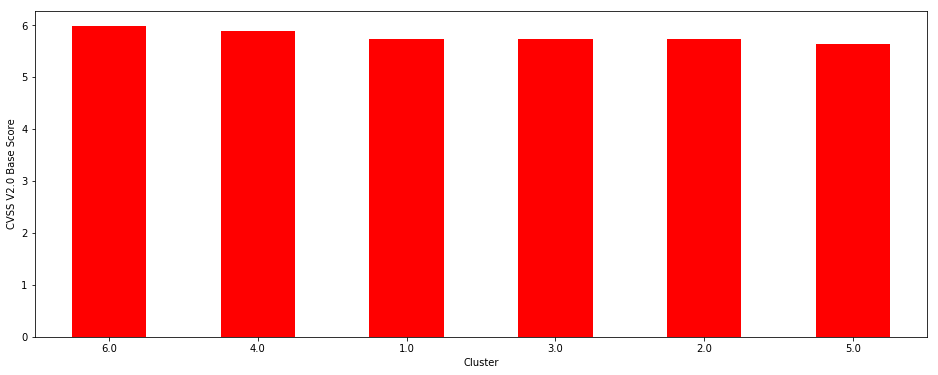

In [1041]:
fig = mean_scores.plot(kind='bar', figsize=(16,6), color='red')
fig.set_ylabel('CVSS V2.0 Base Score');

for tick in fig.get_xticklabels():
    tick.set_rotation(0)

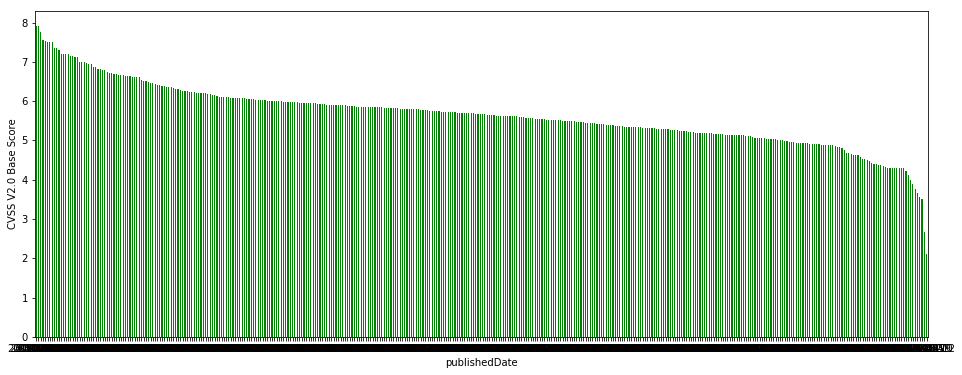

In [1042]:
fig1 = mean_scores_published.plot(kind='bar', figsize=(16,6), color='green')
fig1.set_ylabel('CVSS V2.0 Base Score');

for tick in fig1.get_xticklabels():
    tick.set_rotation(0)

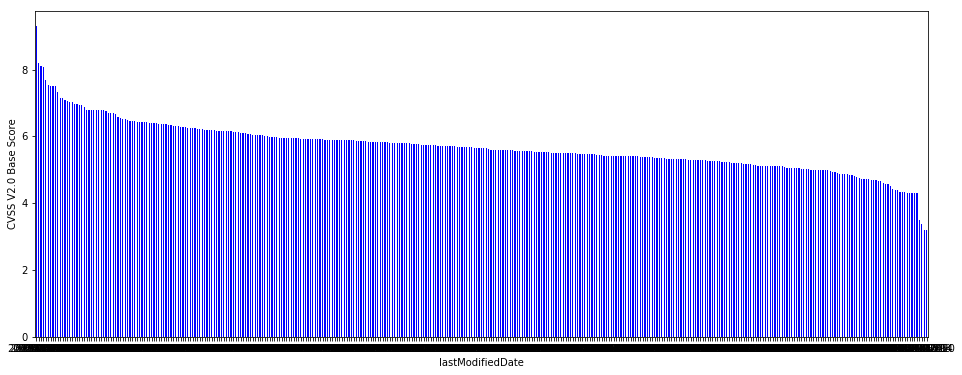

In [1047]:
fig2 = mean_scores_modified.plot(kind='bar', figsize=(16,6), color='blue')
fig2.set_ylabel('CVSS V2.0 Base Score');

for tick in fig2.get_xticklabels():
    tick.set_rotation(0)

In [864]:
# almost uniform
# cluster 6 has the highest peak and thus contains most dangerous cybersecurity vulnerabilities

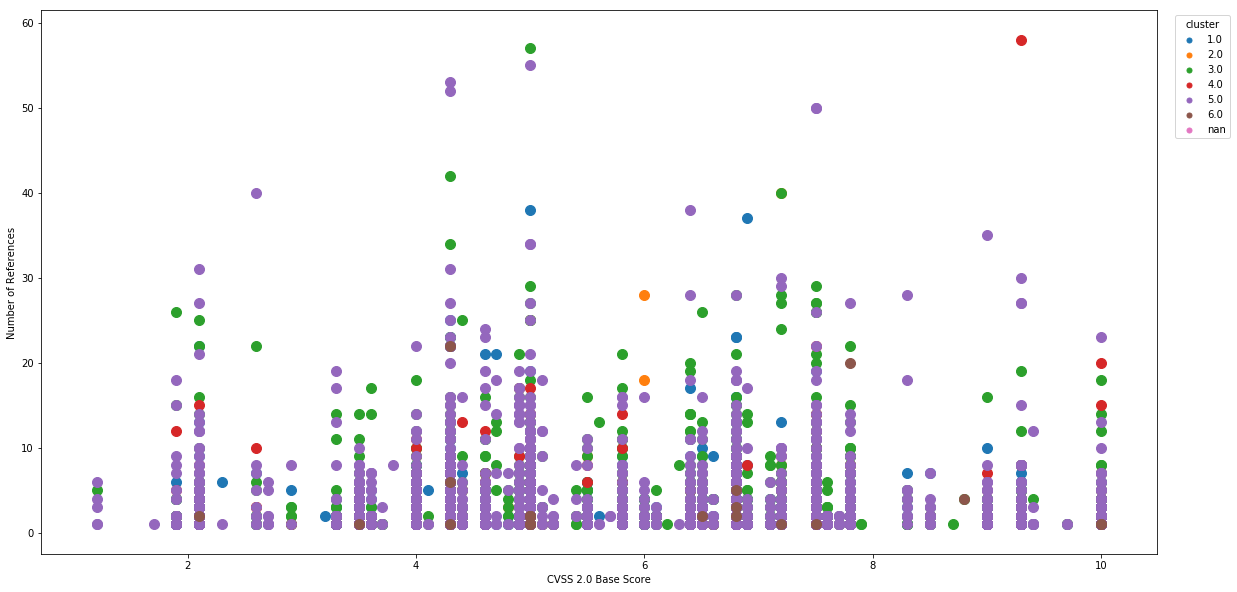

In [1020]:
plt.figure(figsize=(20, 10))
plt.xlabel('CVSS 2.0 Base Score')
plt.ylabel('Number of References')
colors_clusters = list(np.sort(clusters['Cluster'].unique()))
for i in range(len(colors_clusters)):
    temp = clusters.loc[clusters['Cluster'] == colors_clusters[i]]
    plt.scatter('cvssV2_baseScore', 'number_of_references',  s=100, data=temp, label=colors_clusters[i])

leg = plt.legend(markerscale = 0.5, title = 'cluster', loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
plt.show()

In [1021]:
def rand_jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# Source:

# https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


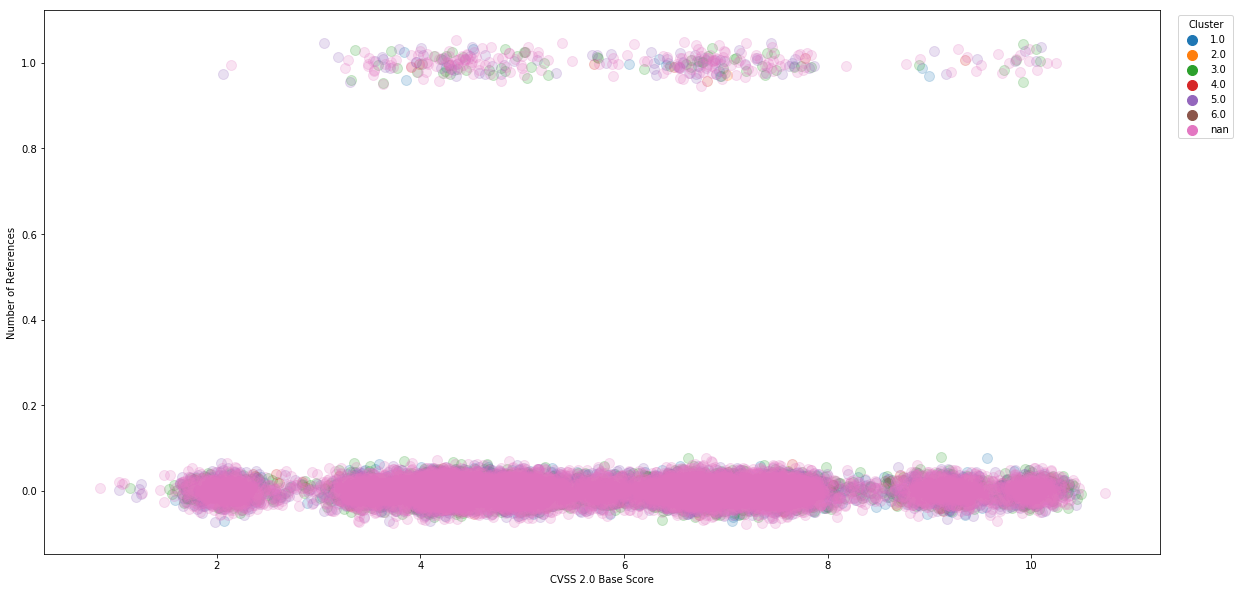

In [1022]:
plt.figure(figsize=(20, 10))
plt.xlabel('CVSS 2.0 Base Score')
plt.ylabel('Number of References')
colors_clusters = list(np.sort(clusters['Cluster'].unique()))
for i in range(len(colors_clusters)):
    temp = clusters.loc[clusters['Cluster'] == colors_clusters[i]]
    # adding random jitter
    temp['cvssV2_baseScore'] = rand_jitter(clusters['cvssV2_baseScore'])
    temp['exploitdb_flag'] = rand_jitter(clusters['exploitdb_flag'])
    plt.scatter('cvssV2_baseScore', 'exploitdb_flag', s=100, alpha=0.2, cmap='set1', data=temp, label=colors_clusters[i])

leg = plt.legend(markerscale=1, title = "Cluster", loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles:
    lh.set_alpha(1)
    
plt.show()

# Insights

> Some CWE codes are more prevalent than others

> Most prevalent are:      
   CWE-79: https://www.cvedetails.com/cwe-details/79/Failure-to-Preserve-Web-Page-Structure-039-Cross-site-Scr.html      
   CWE-20: https://www.cvedetails.com/cwe-details/20/Improper-Input-Validation.html           
   CWE-119: https://www.cvedetails.com/cwe-details/119/Failure-to-Constrain-Operations-within-the-Bounds-of-a-Memor.html   
   CWE-200: https://www.cvedetails.com/cwe-details/200/Information-Exposure.html       
   This was expected and seems logical. For example: in case of CWE-200, an information leak or disclosure is the most common thing to occur when another vulnerability has been discovered.
   
> CVSS V2.0 Base Score: results from a scoring system that rates how severe the security vulnerabilities are, ranges from 0 to 10 and can be divided into particular ranges to measure severity (Low, Medium, High). 
It also suggests which vulnerabilities must be fixed first. In the given data, it doesn't follow a normal distribution and there's no trend seen when we compare the mean CVSS 2.0 Base Scores to their corresponding Common Weakness Enumeration codes which represent commonly seen hardware and software security weaknesses.

> There has been a steady decrease in mean scores over time.

> On applying an unsupervised learning technique in order to identify groups with common properties, kmeans in this case, there wasn't seen much segragation. Cluster 3 and Cluster 5 seem to have dominating effects and plotting CSS V2.0 Base Scores with respect to the Number of References and to the binary feature that represents if there are any references to exploit-db.com doesn't seem visually appealing to the level that it gives us some insight on how the data is segragated based on them.

> Although Cluster 6 contains the highest mean score for CVSS V2.0 Base Score which means that it contains the most dangerous cybersecurity vulnerabilities, it doesn't differ much from the other 5 clusters.

> This means that we require more information in order to conclude some promising insights/trends. For example: Impact Scores would have helped much. I've also read that CVSS V3.0 Base Scores are better choice as they cover a broader aspect. Also, the original JSON file contains much more features which might be relevant for our analysis - that's what I've learned from the NVD website by going through what all of those features represent.

> Also, it seems like CVSS V2.0 Base Score is not a good metric to determine how important a particular vulnerability is.

> As this data was only for a single year (2019), significant trends can be identified by taking data of various years under the picture.

#### What more I could have looked into:

> Changing CVSS V2.0 Base Score into a categorical feature represnting the criticality as either Low, Medium or High. This could have helped to analyse what kind of vulnerabilities were more prevalent during what period of time. Although, this can also be numerically known from the plots and analyses above.

> Time Series Analysis: Growth rate of vulnerabilities with time if I had data spanning over years.

> Total number of references and the flag which represents whether there was a reference to explot-db.com aren't correlated with the any other feature at all and extracting and using relatively more important features will surely help.